## makemore: becoming a backprop ninja

Starting with the notebook shared by AK in lecture video description.

In [ ]:
# there no change change in the first several cells from last lecture

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-04-14 19:44:05--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-04-14 19:44:06 (6.11 MB/s) - ‘names.txt’ saved [228145/228145]



In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [ ]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# ok biolerplate done, now we get to the action:

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [ ]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3493, grad_fn=<NegBackward0>)

In [ ]:
logits.shape

torch.Size([32, 27])

In [ ]:
# Exercise 1: backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

def my_backward():

  # This is how I am going about doing this:
  #
  # 1. Maintain a running derivative, which notes the chain-ed derivative
  #    until that particular layer.
  # 2. At every step, for every variable, we stop and find the local derivative.
  # 3. Gradient of variable = running-derivative multipled with local-derivative.
  #=
  # Problem: While I had conceptually understood how it works, trying to get
  # the derivative right requires the exact, fine details - understanding what
  # is going on, the PyTorch concepts like broadcasting etc., So, I am struggling
  # through this one.
  # For every variable, I will be writing possibly long notes on what exactly
  # is going on with that variable, so that I myself will get clarity to get
  # the derivative right.
  # Maybe this was AK's intention, idk.

  # 1. loss
  # Straight-forward, dloss/dloss = 1.0
  dloss = 1.0

  # 2. logprobs
  # loss = -logprobs[range(n), Yb].mean()
  # What is happening with logprobs?
  # a. probs is a (32, 27) output tensor. There is a row of probabilities for each of
  #    the 32 samples. Each row is probabilities of the 27 characters in our dataset.
  # b. probabilities are very small numbers at this point, so get their logs and
  #    work with their logs => logprobs is also a (32, 27) tensor with each element
  #    in logprobs equal to the natural logarithm of the corresponding element in
  #    prob tensor.
  # c. How do we get from logprobs to loss? Yb is a simple (1, 32) tensor, with
  #    the desired outputs of each of the 32 input samples under process.
  #    If 'a' is the desired output of 0th input sample, we get the log-probability
  #    of 'a' from logprobs[0]. If 'e' is the desired output of the 1st sample, we
  #    get the log-probability of 'e' from logprobs[1]. And this goes on until we
  #    get the log-probabilities of desired-output of each of the 32 input samples.
  # d. The mean of log-probabilities of desired-outputs is computed - which is
  #    a scalar quantity, the loss.
  # e. In particular, logprobs[range(n), Yb] is a simple (1, 32) tensor of all these
  #    32 log-probabilities. The .mean() gets the mean of them.
  #
  # f. Now, let us get onto computing the gradient of logprobs (dlogprobs/dloss)
  # g. loss = =logprobs[range(n), Yb].mean()
  # h. logprobs is (32, 27) tensor. Out of all these 32 x 27 values, only
  #    one in each of the 32 rows is used to compute the loss => Only the ones
  #    that are the log-probabilities of desired-outputs contribute to loss, rest
  #    are not contributing => the gradient of the rest of them now will be 0.
  #    What will be the gradients of the ones which are contributing to loss?
  # i. y = (x1 + x2 + x3)/3. dy/dx1 = 1/3. In essence, gradient of each of the 32
  #    numbers will simply be 1/n, that is 1/32 in this case.
  dlogprobs = torch.zeros_like(logprobs)
  dlogprobs[range(n), Yb] = -1/n
  cmp('logprobs', dlogprobs, logprobs)

  # Note that we take a (32, 27) zero tensor and then set the cells that are
  # contributing to the loss to -1/32.

  # 3. probs
  # logprobs = probs.log()
  # a. logprobs is simply the natural logarithm of probabilities.
  # b. probs is a (32, 27) tensor, and every element is contributing to logprobs.
  # c. Its local derivative dlogprobs/dprobs will also be a (32, 27) tensor.
  # d. d(logx) = 1/x, local derivative dlogprobs/dprobs = (1/probs)
  dprobs = (1.0 / probs) * dlogprobs
  cmp('probs', dprobs, probs)

  # 4. counts_sum_inv
  # probs = counts * counts_sum_inv
  # counts ->         (32, 27)
  # counts_sum_inv -> (32,  1)
  # Local derivative: dprobs/dcounts_sum_inv
  # Going by the scalar derivative rule, dprobs/dcounts_sum_inv = counts
  # So, that way, actual gradient that way will be counts * dprobs,
  # which will result in a (32, 27) tensor. - I don't think that is correct.
  #
  # I think the way that tensor multiplication is working is that the
  # (32, 1) tensor is converted/broadcasted into a (32, 27) tensor, then
  # an element by element multiplication happens (that is normal).
  #
  # Okay, let me go step by step.
  # 1. counts_sum_inv (32, 1) is broadcasted into (32, 27) tensor.
  # 2. Multiplication of counts (32, 32) with broadcasted (32, 27) tensor is computed
  #
  # Local derivative for this multiplication operation is "counts". But how do we
  # deal with the broadcasting here? Because dcounts_sum_inv cannot be a (32, 27) tensor.
  # It needs to be a (32, 1) tensor like counts_sum_inv.
  #
  # Okay, what I understand from reading up is when broadcasting from (32, 1) to
  # (32, 27) happens, each duplicate element (in a row) contributes to the gradient.
  # So, we need to sum up all the 27 contributions in each row giving rise to a
  # (32, 1) tensor.
  #
  # Note that the sum is taken on the final derivative, not on local derivative.
  #
  dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
  cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

  # 5. counts_sum
  # counts_sum_inv = counts_sum**-1
  # counts_sum_inv -> (32, 1)
  # counts_sum     -> (32, 1)
  # A simple element by element operation.
  # d (1/x)/dx = -1/(x**2) <- can be applied directly.
  # Derivative will also be a (32, 1) tensor.
  # Local Derivative = dcounts_sum_inv/dcounts_sum = -1/(counts_sum**2)
  dcounts_sum = (-1.0 / (counts_sum**2)) * dcounts_sum_inv
  cmp('counts_sum', dcounts_sum, counts_sum)

  # 6. counts
  # counts is used in two places:
  # a. probs = counts * counts_sum_inv
  # b. counts_sum = counts.sum(1, keepdim = True)
  # We need to find gradients in both cases. And remember saying these
  # gradients get added, so we'll need to sum them up.
  # a. probs = counts * counts_sum_inv
  # probs ->       (32, 27)
  # counts ->      (32, 27)
  # counts_sum_inv (32,  1)
  dcounts1 = (counts_sum_inv * dprobs)

  # b. counts_sum = counts.sum(1, keepdim=True)
  # counts_sum -> (32,  1)
  # counts     -> (32, 27)
  # y = (x1 + x2 + x3), so dy/dx1 = 1.0, each element contributes a unit gradient.
  # I think the same can be applied here.
  # In a row (with 27 variables in it), all of them are summed, so each of the 27
  # variables is contributing unit gradient.
  # Local Derivative = dcounts_sum/dcounts = A (32, 27) unit tensor
  dcounts2 = torch.ones_like(counts) * dcounts_sum

  # Now, both the gradients get added (really need to check the math behind this)
  dcounts = dcounts1 + dcounts2
  cmp('counts', dcounts, counts)

  # 7. norm_logits
  # counts = norm_logits.exp()
  # norm_logits -> (32, 27)
  # counts ->      (32, 27)
  # Simple, element by element exponentiation.
  # d(e**x)/dx = e**x
  # Local derivative = dcounts/dnorm_logits = counts
  dnorm_logits = counts * dcounts
  cmp('norm_logits', dnorm_logits, norm_logits)

  # 8. logits_maxes
  # a. norm_Logits = logits - logitmaxes
  # norm_logits   -> (32, 27)
  # logit_maxes   -> (32,  1) --> (32, 27) broadcasted tensor
  #
  # The derivative on the broadcasted (32, 27) tensor is negative-unit tensor
  # of (32, 27) dimensions.
  # Then we sum the gradients in each of the rows to give a (32, 1) gradient tensor.
  # a. Start with a (32, 27) unit tensor.
  # b. Multiply it with dnorm_digits (32, 27) tensor to get the gradients.
  # c. Sum the rows to give a (32, 1) gradient tensor.
  # d. Finally multiply by a -1.0 (because norm_logits = logitx - logit_maxes)
  dlogit_maxes = (-1.0) * (torch.ones_like(logit_maxes) * dnorm_logits).sum(1, keepdim=True)
  cmp('logit_maxes', dlogit_maxes, logit_maxes)

  # 9. logits
  # a. norm_logits = logits - logit_maxes
  # b. logit_maxes = logits.max(1, keepdim=True).value
  #
  # Start with (a) norm_logits = logits - logit_maxes
  # norm_logits -> (32, 27)
  # logits      -> (32, 27)
  # An element by element operation, so local derivative is a unit tensor (all ones)
  dlogits1 = torch.ones_like(norm_logits) * dnorm_logits


  # b. logit_maxes = logits.max(1, keepdim=True).value
  #
  # logit_maxes -> (32,  1)
  # logits      -> (32, 27)
  #
  # Intuitively, only the max values in each row are contributing to the gradient,
  # rest all are zeros. So, we start with a zero-tensor (32, 27), update the indices
  # of max-values with 1.0.
  dlogits2 = torch.zeros_like(logits)
  dlogits2[torch.arange(n), logits.max(1).indices] = 1.0
  dlogits2 *= dlogit_maxes  # Local derivative * previous derivative
  dlogits = dlogits2 + dlogits1 # Accrual of gradients
  cmp('logits', dlogits, logits)

  # 10. b2
  # logits = h @ W2 + b2
  # logits -> (32, 27)
  # b2     -> (1,  27) --> broadcasted into (32, 27) (1 row replicated 32 times)
  # We start with a (32, 27) unit tensor, multiply it with dlogits (let the
  # gradients flow), we now have a (32, 27) tensor with gradients.
  # What is the correct way to squash this into a (1, 27) tensor?
  # local derivative = dlogits/db2
  db2 = (torch.ones_like(logits) * dlogits).sum(0, keepdim=True)
  cmp('b2', db2, b2)

  # 11. h
  # logits = h @ W2 + b2
  # logits  -> (32, 27)
  # h       -> (32, 64)
  # W2      -> (64, 27)
  # Each hij contributes to logits. We need to find exactly how it contributes
  # and by how much.
  # Because it is a dot product, every hij contributes wjk amount to logits-ik.
  # - I believe the gradient dlogits is magnified/diminished through wjk.
  # - So, every hij contributes a summation of gradient-contri * wjk
  # - To find the gradient-contri, I need to understand how exactly does gradient
  #   flow from logits to h.
  # dlogits     -> (32, 27)
  # W           -> (64, 27)
  # W-Transpose -> (27, 64)
  #
  # The derivative is essentially dlogits * W-Transpose   (I took a lot of time
  # to figure this out, on paper. AK showed it in a very simple manner)
  #
  dh = dlogits @ W2.T
  cmp('h', dh, h)

  # 12. W2
  # logits = h @ W2 + b2
  # logits  -> (32, 27)
  # h       -> (32, 64)
  # W2      -> (64, 27)
  #
  # dlogits -> (32, 27)
  # h       -> (32, 64)
  #
  # Purely going by dimensionality, we do a h.T @ dlogits
  # Checked on paper, similar to h but with a bit of difference
  dW2 = h.T @ dlogits
  cmp('W2', dW2, W2)

  # 13. hpreact
  # h = torch.tanh(hpreact)
  # This is a simple element by element operation.
  dhpreact = (1.0 - h**2) * dh
  cmp('hpreact', dhpreact, hpreact)

  # Got an approximate True for hpreact. Needs checking.
  # I think from here, all gradients will be approximate.

  # 14. bnbias
  # hpreact = bngain * bnraw + bnbias
  # hpreact -> (32, 64)
  # bnbias  -> ( 1, 64) -> broadcasted into (32, 64)
  # For the broadcasted tensor (32, 64), the local derivative is simply a (32, 64) unit tensor.
  # d-broadcasted-tensor = local-derivative * dh (element by element multiplication)
  #
  # Then we add up along dimension 0 (adding all the gradients)
  dbnbias = (torch.ones_like(hpreact) * dhpreact).sum(0, keepdim=True)
  cmp('bnbias', dbnbias, bnbias)

  # 15. bngain
  # hpreact = bngain * bnraw + bnbias
  # hpreact -> (32, 64)
  # bngain  -> ( 1, 64) -> broadcasted to (32, 64), then multiplication.
  # bnraw   -> (32, 64)
  #
  # Local derivative for the broadcasted tensor is simply bnraw, gradient is bnraw * dhpreact.
  # Then we add the gradients along dimension 0 to get a (1, 64) tensor.
  dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
  cmp('bngain', dbngain, bngain)

  # 16. bnraw
  # Simple multiplication of bngain * dhpreact
  # bngain is broadcasted into a (32, 64)
  dbnraw = bngain * dhpreact
  cmp('bnraw', dbnraw, bnraw)

  # 17. bndiff
  # bnraw = bndiff * bnvar_inv
  # bnraw -> (32, 64)
  # bndiff -> (32, 64)
  # bnvar_inv -> (1, 64) -> broadcasted into a (32, 64) and then element-level mul.
  dbndiff_1 = dbnraw * bnvar_inv

  # 18. bnvar_inv
  dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
  cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

  # 19. bnvar
  # bnvart_inv = (bnvar + 1e-5)**-0.5
  dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
  cmp('bnvar', dbnvar, bnvar)

  # 20. bndiff2
  # bnvar = 1/(n-1) * (bndiff2).sum(0, keepdim=True)
  # bnvar ->   ( 1, 64)
  # bndiff2 -> (32, 64)
  # We have seen that in a summation case, each element contributes unit gradient.
  dbndiff2 = 1/(n-1) * torch.ones_like(bndiff2) * dbnvar
  cmp('bndiff2', dbndiff2, bndiff2)

  # 21. bndiff
  # bndiff2 = bndiff**2
  # Simple arithmetic op => element by element op.
  dbndiff_2 = 2 * bndiff * dbndiff2
  dbndiff = dbndiff_1 + dbndiff_2
  cmp('bndiff', dbndiff, bndiff)

  # 22. bnmeani
  # bndiff = hprebn - bnmeani
  # bndiff -> (32, 64)
  # hprebn -> (32, 64)
  # bnmeani-> ( 1, 64) -> broadcasted into (32, 64) and then subtracted.
  # Take the broadcasted tensor first, each element in it contributes unit gradient,
  # multiply that with dbndiff. Then sum it up along dimension 0 and multiply
  # the whole thing by -1.0 (because bnmeani is being subtracted)
  dbnmeani = (-1.0) * (torch.ones_like(bnmeani) * dbndiff).sum(0, keepdim=True)
  cmp('bnmeani', dbnmeani, bnmeani)

  # 23. hprebn
  # bndiff = hprebn - bnmeani
  # Simple unit gradient multiplied by dbndiff
  dhprebn_1 = torch.ones_like(hprebn) * dbndiff

  # bnmeani = 1/n*hprebn.sum(0, keepdim=True)
  dhprebn_2 = 1/n * torch.ones_like(hprebn) * dbnmeani

  dhprebn = dhprebn_1 + dhprebn_2
  cmp('hprebn', dhprebn, hprebn)


  # 24. b1
  # hprebn = embcat @ W1 + b1
  # hprebn -> (32, 64)
  # embcat -> (32, 30)
  # W1     -> (30, 64)
  # b1     -> ( 1, 64)
  #
  # Simply following the previous linear layer (refer b2/10)
  db1 = (torch.ones_like(hprebn) * dhprebn).sum(0, keepdim=True)
  cmp('b1', db1, b1)

  # 25. W1
  dW1 = embcat.T @ dhprebn
  cmp('W1', dW1, W1)

  # 26. embcat
  dembcat = dhprebn @ W1.T
  cmp('embcat', dembcat, embcat)

  # 27. emb
  demb = dembcat.view(emb.shape)
  cmp('emb', demb, emb)

  # 27. C
  # C
  # Understood from AK's explanation.
  dC = torch.zeros_like(C)
  for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
      ix = Xb[k, j]
      dC[ix] += demb[k, j]
  cmp('C', dC, C)

In [ ]:
## Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()




# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.34928822517395 diff: 4.76837158203125e-07


In [ ]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

# -----------------
# YOUR CODE HERE :)
#dlogits = None # TODO. my solution is 3 lines
# -----------------

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


In [ ]:
dlogits[0] * n

tensor([ 0.0764,  0.0840,  0.0199,  0.0500,  0.0192,  0.0858,  0.0246,  0.0367,
        -0.9826,  0.0304,  0.0357,  0.0382,  0.0351,  0.0271,  0.0336,  0.0131,
         0.0096,  0.0192,  0.0154,  0.0523,  0.0506,  0.0232,  0.0237,  0.0700,
         0.0606,  0.0265,  0.0218], grad_fn=<MulBackward0>)

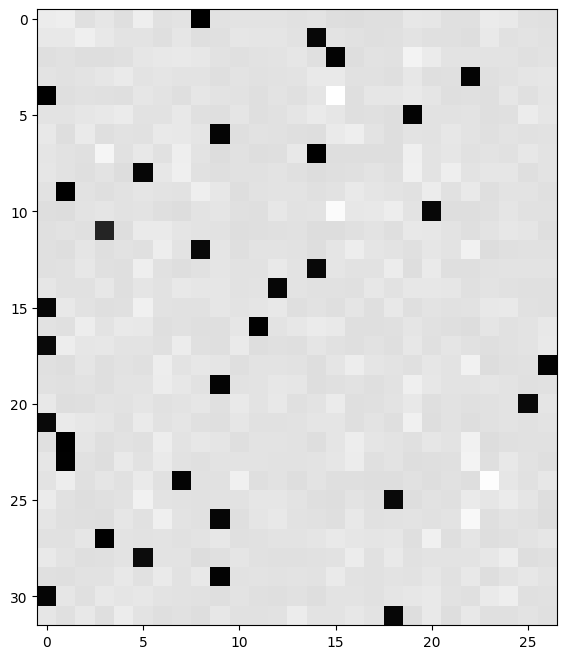

In [ ]:
plt.figure(figsize=(8, 8))
plt.imshow(dlogits.detach(), cmap='gray')

In [ ]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [ ]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

# -----------------
# YOUR CODE HERE :)
dnprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum() - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

# -----------------

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    # YOUR CODE HERE :)
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    #1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    #embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
    #dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #   break

12297
      0/ 200000: 3.7890
  10000/ 200000: 2.2269
  20000/ 200000: 2.3360
  30000/ 200000: 2.4257
  40000/ 200000: 1.9844
  50000/ 200000: 2.3804
  60000/ 200000: 2.4329
  70000/ 200000: 2.1047
  80000/ 200000: 2.3134
  90000/ 200000: 2.1183
 100000/ 200000: 1.9760
 110000/ 200000: 2.3081
 120000/ 200000: 1.9947
 130000/ 200000: 2.5402
 140000/ 200000: 2.2731
 150000/ 200000: 2.1745
 160000/ 200000: 2.0040
 170000/ 200000: 1.8870
 180000/ 200000: 2.1062
 190000/ 200000: 1.8576


In [ ]:
#useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

TypeError: all() received an invalid combination of arguments - got (bool), but expected one of:
 * (Tensor input, *, Tensor out = None)
 * (Tensor input, tuple of ints dim = None, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, int dim, bool keepdim = False, *, Tensor out = None)
 * (Tensor input, name dim, bool keepdim = False, *, Tensor out = None)


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [ ]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.678286075592041
val 2.6766111850738525


In [ ]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kmyaz.
hzen.
edhn.
amarethr.
jekgrleg.
azeredie.
iulemi.
jea.
ekein.
anwaarieltzi.
hvqep.
b.
shdbn.
gxhiries.
kkkjrwellqhxntpocfnuaz.
gvda.
hylquemehs.
kaajqhoflyan.
hjan.
